In [47]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LOWER_DELETION_SIZE_LIMIT = 4000
UPPER_DELETION_SIZE_LIMIT = 10000
DELETION_ALLELE_FREQ_THRESHOLD = 0.00001

# Filter out false deletions: 
SUSPICIOUS_DELETION_SIZE_THRESHOLD = 1000000

DELETION_CLASS = 'observed' # TOPMED 

# DELETION_TYPE = 'long' 
DELETION_TYPE = 'all' 

# create windows by subtracting 0.5*WINDOW_SIZE from enhancer_center and adding 0.5*WINDOW_SIZE to enhancer_center 
WINDOW_SIZE = 100000


## Get deletion coordinates relative to centers of enhancers 

In [52]:
from shell import shell
import pandas as pd

def f(): 
  # TODO: replace "XXX" with something more informative 
  windows_with_deletions = f'{CONSTRAINT_TOOLS_DATA}/windows-XXX-intersect-{DELETION_TYPE}-{DELETION_CLASS}-deletions.bed'

  intersect_script = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-windows-XXX-with-deletions.sh'

  cmd = (
    f'bash '
    f'{intersect_script} '
    f'{DELETION_CLASS} {windows_with_deletions} '
    f'{DELETION_TYPE} '
    f'{LOWER_DELETION_SIZE_LIMIT} {UPPER_DELETION_SIZE_LIMIT} {DELETION_ALLELE_FREQ_THRESHOLD} '
    f'{SUSPICIOUS_DELETION_SIZE_THRESHOLD} '
    f'{WINDOW_SIZE}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    windows_with_deletions, 
    sep='\t',
  )

  return df 

DF = f() 
DF


Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/windows-XXX-intersect-all-observed-deletions.bed



,window_chrom,window_start,window_end,#chrom,start,end,GHid,element,elite,gene_association|score|elite,...,SAS_Male_Het,SAS_Male_HomAlt,SAS_Male_HemiAlt,SAS_Male_HemiAF,SAS_Female_AF,SAS_Female_HomRef,SAS_Female_Het,SAS_Female_HomAlt,PopMax_AF,InPop
0,chr1,680600,780600,chr1,730200,731000,GH01J000730,Enhancer,0,piR-34364-003|750.64|1;piR-36473-003|750.64|1;...,...,0,0,0,0.000000,0.000000,1375,0,0,0.000006,1
1,chr1,684400,784400,chr1,733800,735000,GH01J000733,Enhancer,0,piR-34364-004|750.64|1;piR-37834-005|750.64|1;...,...,0,0,0,0.000000,0.000000,1375,0,0,0.000006,1
2,chr1,687600,787600,chr1,737000,738201,GH01J000737,Enhancer,0,piR-34364-005|750.64|1;piR-37834-006|750.64|1;...,...,0,0,0,0.000000,0.000000,1375,0,0,0.000006,1
3,chr1,690500,790500,chr1,740201,740800,GH01J000740,Enhancer,0,LOC100133331|750.64|1;piR-34364-006|750.64|1;p...,...,0,0,0,0.000000,0.000000,1375,0,0,0.000006,1
4,chr1,694313,794313,chr1,744027,744600,GH01J000744,Enhancer,0,piR-43166-003|750.64|1;piR-50122-003|750.64|1;...,...,0,0,0,0.000000,0.000000,1318,0,0,0.000006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760604,chrX,155665800,155765800,chrX,155715601,155716000,GH0XJ155715,Enhancer,0,TMLHE|10.9|0;piR-44450|0.35|0;piR-46847-307|0....,...,0,0,9,0.002802,0.004818,1336,13,0,0.017279,6
3760605,chrX,155665800,155765800,chrX,155715601,155716000,GH0XJ155715,Enhancer,0,TMLHE|10.9|0;piR-44450|0.35|0;piR-46847-307|0....,...,0,0,0,0.000000,0.000364,1373,1,0,0.000168,1
3760606,chrX,155665800,155765800,chrX,155715601,155716000,GH0XJ155715,Enhancer,0,TMLHE|10.9|0;piR-44450|0.35|0;piR-46847-307|0....,...,0,0,0,0.000000,0.000000,1372,0,0,0.000015,1
3760607,chrX,155665800,155765800,chrX,155715601,155716000,GH0XJ155715,Enhancer,0,TMLHE|10.9|0;piR-44450|0.35|0;piR-46847-307|0....,...,0,0,0,0.000000,0.000000,1270,0,0,0.000030,1


In [53]:
def g(df, singleton): 
  df = df[
    (df['window_chrom'] != 'chrX') &
    (df['window_chrom'] != 'chrY')
  ]
  df = df[df['element'] == 'Enhancer']  
  df = df[df['elite'] == 1]
  df['singleton'] = df['Het'] == 1
  df = df[df['singleton'] == singleton]
  df = df[['window_chrom', 'window_start', 'window_end', 'START', 'END', 'Het', 'singleton']]

  df = df.rename(columns={
    'START': 'deletion_start',
    'END': 'deletion_end',
    'Het': 'number_of_het_samples'
  })

  df['window_center'] = (df['window_start'] + df['window_end']) / 2
  df['deletion_start_new'] = df['deletion_start'] - df['window_center']
  df['deletion_end_new'] = df['deletion_end'] - df['window_center']

  df['deletion_start_new'] = df['deletion_start_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)
  df['deletion_end_new'] = df['deletion_end_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)

  return df[['deletion_start_new', 'deletion_end_new']].to_records(index=False).tolist()

g(DF, singleton=False)


[(335.0, 1206.0),
 (9515.0, 9561.0),
 (10514.0, 13035.0),
 (38410.0, 43457.0),
 (39899.0, 44399.0),
 (1339.0, 50000.0),
 (1399.0, 50000.0),
 (12110.0, 15912.0),
 (14465.0, 50000.0),
 (20690.0, 35801.0),
 (20699.0, 37099.0),
 (21299.0, 37099.0),
 (-14964.0, -14093.0),
 (-5784.0, -5738.0),
 (-4785.0, -2264.0),
 (23111.0, 28158.0),
 (24600.0, 29100.0),
 (49753.0, 50000.0),
 (-13960.0, 50000.0),
 (-13900.0, 50000.0),
 (-3189.0, 613.0),
 (-834.0, 50000.0),
 (5391.0, 20502.0),
 (5400.0, 21800.0),
 (6000.0, 21800.0),
 (-22265.0, -21394.0),
 (-13085.0, -13039.0),
 (-12086.0, -9565.0),
 (15810.0, 20857.0),
 (17299.0, 21799.0),
 (42452.0, 50000.0),
 (43236.0, 46556.0),
 (-21261.0, 50000.0),
 (-21201.0, 50000.0),
 (-10490.0, -6688.0),
 (-8135.0, 50000.0),
 (-1910.0, 13201.0),
 (-1901.0, 14499.0),
 (-1301.0, 14499.0),
 (43480.0, 50000.0),
 (-31164.0, -30293.0),
 (-21984.0, -21938.0),
 (-20985.0, -18464.0),
 (6911.0, 11958.0),
 (8400.0, 12900.0),
 (33553.0, 43000.0),
 (34337.0, 37657.0),
 (41589.0,

## Visualize pileup of deletions in the vicinity of enhancers
https://www.nxn.se/valent/visualizing-overlapping-intervals

In [ ]:
# TODO 
# color deletions by singleton status 

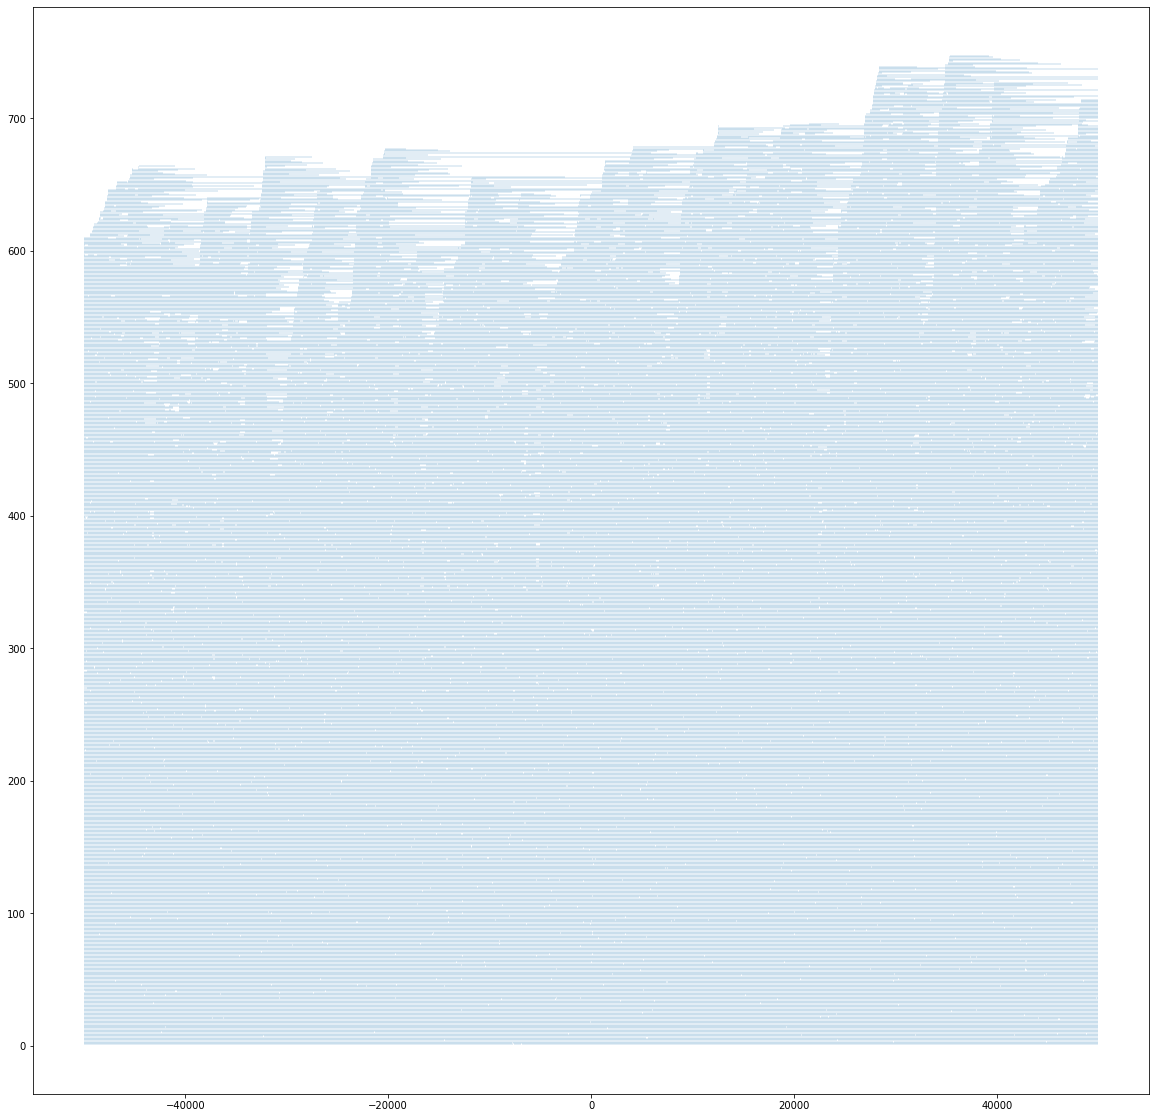

In [64]:
import matplotlib.pyplot as plt

# intervals = [(2, 6), (7, 10), (1, 3), (4, 6), (8, 10), (1, 2), (3, 7), (9, 10), (1, 2), (3, 5), (6, 7), (8, 10), (2, 5), (8, 10)]
intervals = g(DF, singleton=False)[:10000]

def intervals2layers(si):
    layers = [[si[0]]]
    for p in si[1:]:
        for lay in layers:
            if lay[-1][-1] < p[0]:
                lay.append(p)
                break
        else:
            layers.append([p])

    return layers

si = sorted(intervals, key=lambda p: p[0])
layers = intervals2layers(si)

plt.figure(figsize=(20, 20))

for i, lay in enumerate(layers):
    x1, x2 = zip(*lay)
    plt.hlines([i + 1] * len(x1), x1, x2, lw=0.25)


# plt.xlim(0, 11)
# plt.ylim(0, 6)

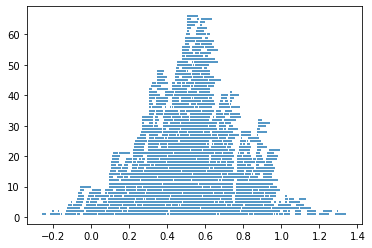

In [40]:
import random 

intervals = []
for i in range(1024):
    x1 = random.normalvariate(0.5, 0.25)
    x2 = x1 + random.random() / 16
    intervals.append((x1, x2))

si = sorted(intervals, key=lambda p: p[0])
layers = intervals2layers(si)

for i, lay in enumerate(layers):
    x1, x2 = zip(*lay)
    plt.hlines([i + 1] * len(x1), x1, x2)


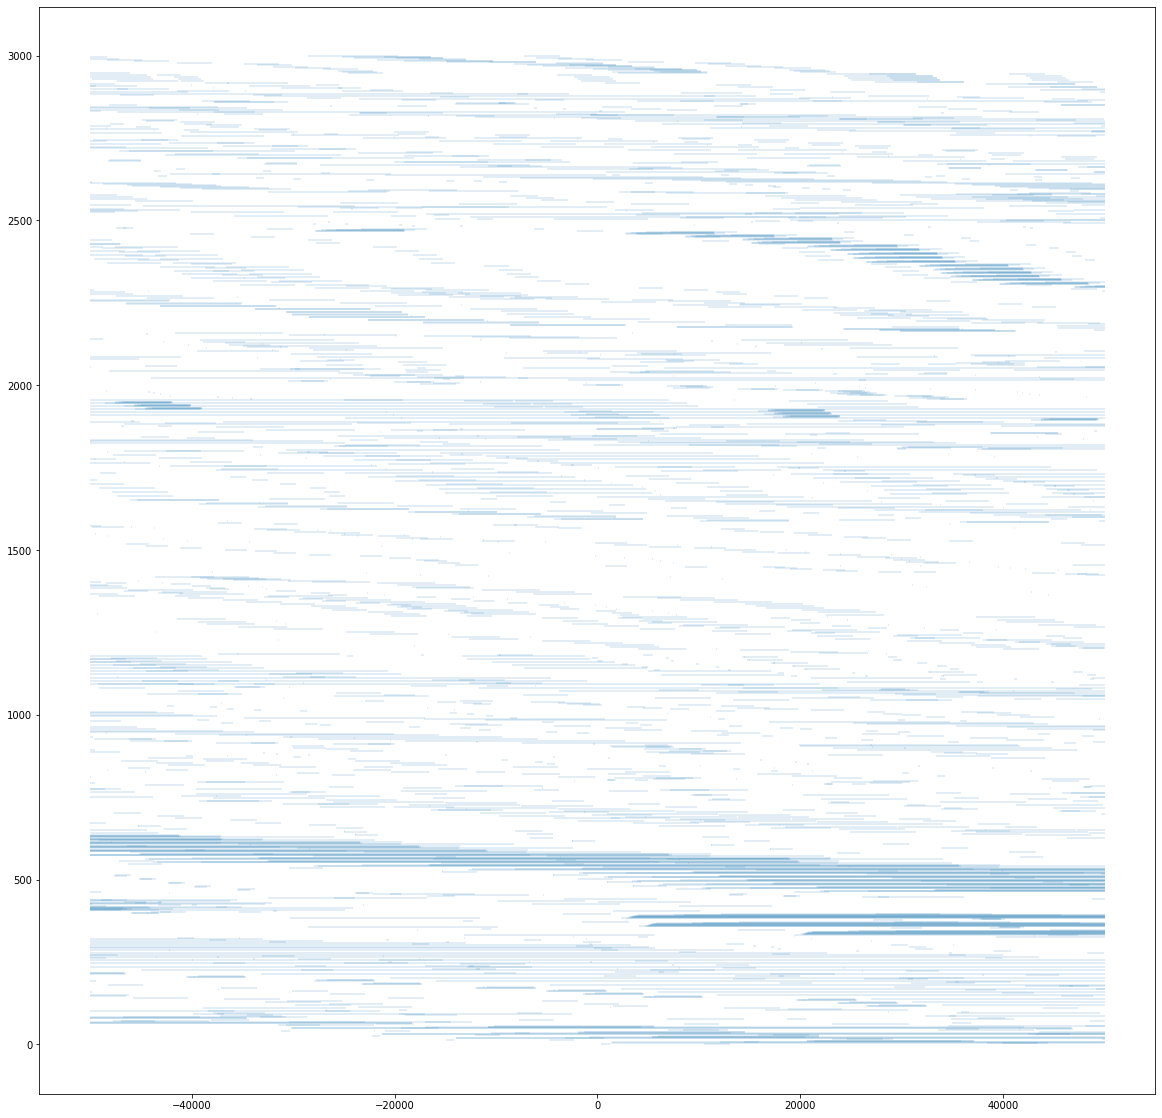

In [60]:
# intervals = [(2, 6), (7, 10), (1, 3), (4, 6), (8, 10), (1, 2), (3, 7), (9, 10), (1, 2), (3, 5), (6, 7), (8, 10), (2, 5), (8, 10)]
intervals = g(DF, singleton=False)[:3000]

plt.figure(figsize=(20, 20))

for i, interval in enumerate(intervals):
    x1, x2 = interval
    plt.hlines(i, x1, x2, lw=0.25)


# plt.xlim(0, 11)
# plt.ylim(0, 6)

(array([ 58656.,  59054.,  59296.,  59231.,  59334.,  58886.,  58785.,
         58827.,  59384., 122703.]),
 array([-4.99990e+04, -3.99991e+04, -2.99992e+04, -1.99993e+04,
        -9.99940e+03,  5.00000e-01,  1.00004e+04,  2.00003e+04,
         3.00002e+04,  4.00001e+04,  5.00000e+04]),
 <BarContainer object of 10 artists>)

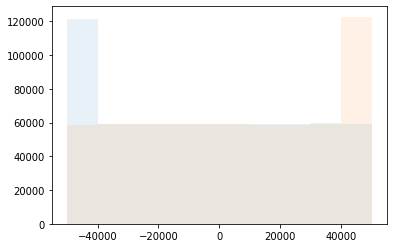

In [62]:
intervals = g(DF, singleton=False)

x1, x2 = zip(*intervals)

plt.hist(x1, alpha=0.5)
plt.hist(x2, alpha=0.5)


## [TODO] Repeat analysis, but replacing enhancers with exons 

## Compute per-bp coverage of deletions in the vicinity of enhancers

https://www.geeksforgeeks.org/maximum-number-of-overlapping-intervals/ 

In [ ]:
# TODO 
# Generalize the code below to include a per-bp coverage variable that is updated as the intervals are traversed 

In [ ]:
# Python3 program that print maximum
# number of overlap
# among given ranges

# Function that print maximum
# overlap among ranges
def overlap(v):

	# variable to store the maximum
	# count
	ans = 0
	count = 0
	data = []

	# storing the x and y
	# coordinates in data vector
	for i in range(len(v)):

		# pushing the x coordinate
		data.append([v[i][0], 'x'])

		# pushing the y coordinate
		data.append([v[i][1], 'y'])

	# sorting of ranges
	data = sorted(data)

	# Traverse the data vector to
	# count number of overlaps
	for i in range(len(data)):

		# if x occur it means a new range
		# is added so we increase count
		if (data[i][1] == 'x'):
			count += 1

		# if y occur it means a range
		# is ended so we decrease count
		if (data[i][1] == 'y'):
			count -= 1

		# updating the value of ans
		# after every traversal
		ans = max(ans, count)

	# printing the maximum value
	print(ans)

# Driver code
v = [ [ 1, 2 ], [ 2, 4 ], [ 3, 6 ] ]
overlap(v)

# This code is contributed by mohit kumar 29
